In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# use the keras.utils.get_file method to download the dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(
    fname="flower_photos",
    origin=dataset_url,
    untar=True,
    cache_dir="."
)

In [3]:
import pathlib

In [4]:
# convert to Path object
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob("*/*.jpg")))
image_count

3670

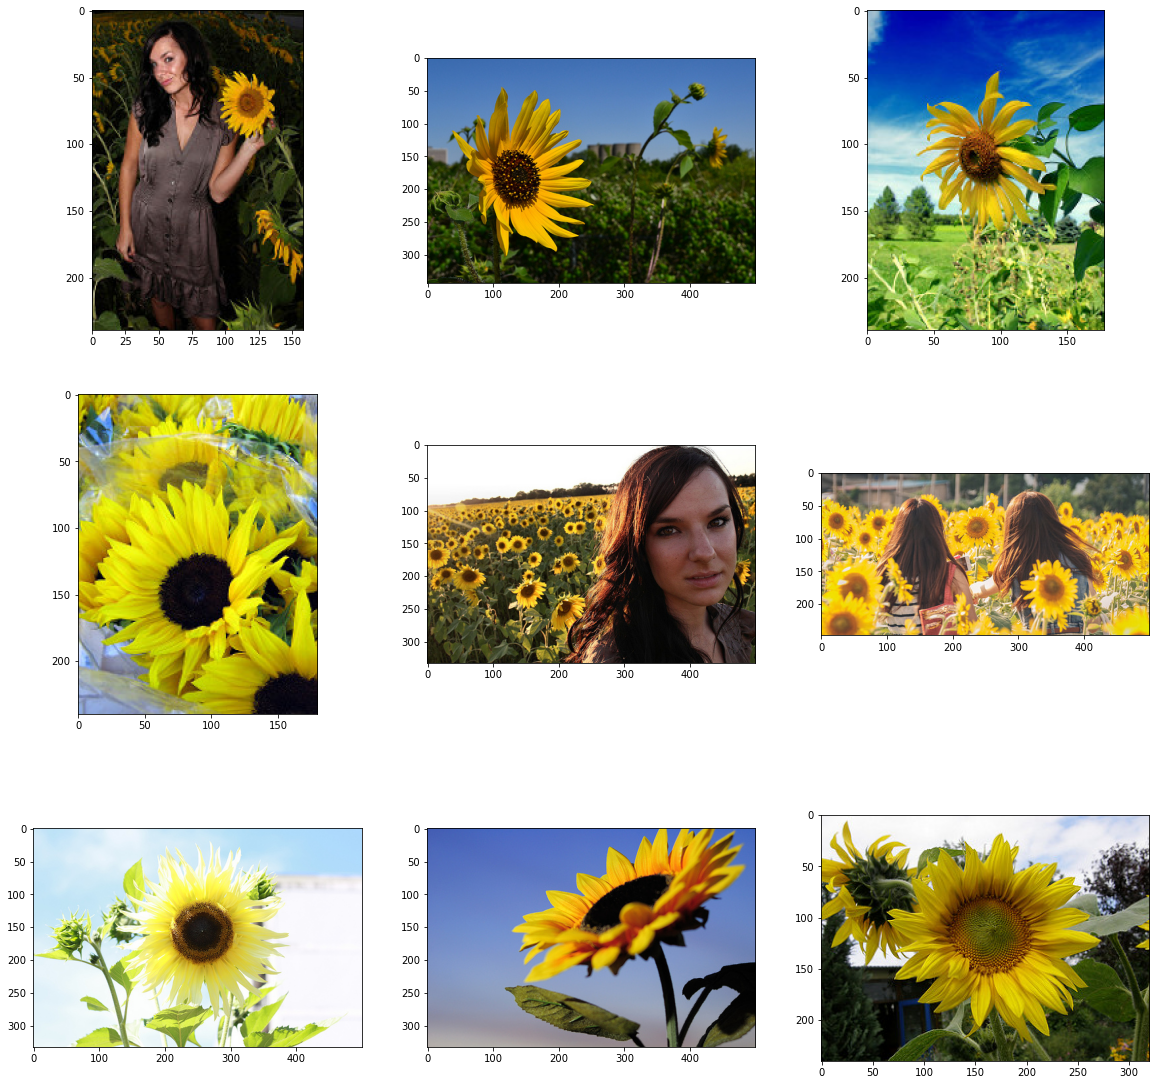

In [5]:
# plot roses
roses = list(data_dir.glob("sunflowers/*.jpg"))
roses_count = len(roses)
plot_count = 9
random_indices = [np.random.randint(0,roses_count) for count in range(plot_count)]

plt.figure(figsize=(20,20))
for images in range(plot_count):
    plt.subplot(3,3,images+1)
    plt.imshow(cv2.imread(str(roses[random_indices[images]]))[:,:,::-1])

Training set  = 80%; Validation set = 10%; Testing set = 10%

In [6]:
# load images off disk using keras.utils.image_dataset_from_directory
# set parameters
batch_size = 32
img_height = 180
img_width = 180

In [7]:
# training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
# validation and testing set
val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
# create separate validation and testing datasets
val_test_size = len(val_test_ds)
val_test_ds = val_test_ds.shuffle(50)
val_ds = val_test_ds.take(int(0.5*val_test_size))
test_ds = val_test_ds.skip(int(0.5*val_test_size))

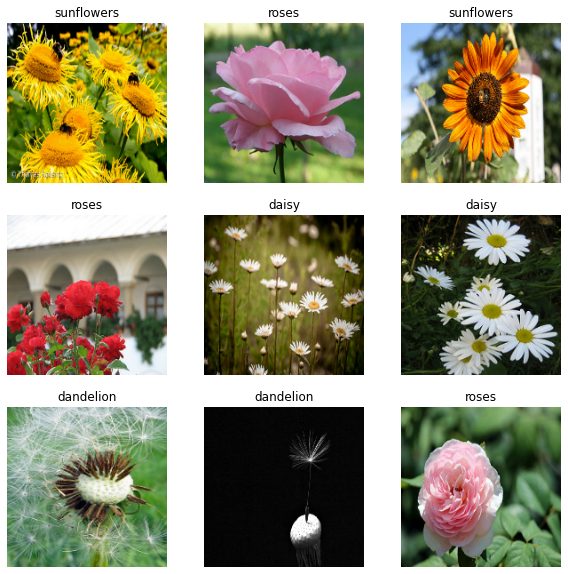

In [10]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [68]:
# train without augmentation
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [69]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [70]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
92/92 [==============================] - 61s 658ms/step - loss: 1.3229 - accuracy: 0.4264 - val_loss: 1.1345 - val_accuracy: 0.5657
Epoch 2/15
92/92 [==============================] - 63s 677ms/step - loss: 1.0300 - accuracy: 0.5971 - val_loss: 1.0579 - val_accuracy: 0.5739
Epoch 3/15
92/92 [==============================] - 59s 636ms/step - loss: 0.8710 - accuracy: 0.6594 - val_loss: 0.9753 - val_accuracy: 0.6143
Epoch 4/15
92/92 [==============================] - 58s 635ms/step - loss: 0.6890 - accuracy: 0.7398 - val_loss: 0.9556 - val_accuracy: 0.6371
Epoch 5/15
92/92 [==============================] - 53s 570ms/step - loss: 0.4883 - accuracy: 0.8300 - val_loss: 1.1391 - val_accuracy: 0.6429
Epoch 6/15
92/92 [==============================] - 64s 696ms/step - loss: 0.3002 - accuracy: 0.8944 - val_loss: 1.5033 - val_accuracy: 0.6057
Epoch 7/15
92/92 [==============================] - 58s 626ms/step - loss: 0.1845 - accuracy: 0.9397 - val_loss: 1.4691 - val_accuracy: 0.6676

In [63]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

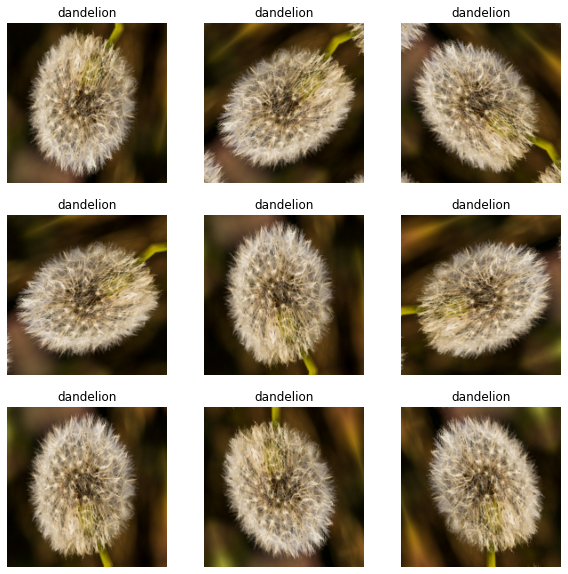

In [64]:
# plot examples of a data augmented image using the previous pipeline
EXAMPLE = 5

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    image = tf.cast(tf.expand_dims(images[EXAMPLE], 0), tf.float32)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_img = data_augmentation(image)
        plt.imshow(augmented_img[0].numpy().astype("uint8"))
        plt.title(class_names[labels[EXAMPLE]])
        plt.axis("off")

In [65]:
# train with augmentation
num_classes = 5

model_with_augmentation = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [66]:
model_with_augmentation.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [67]:
model_with_augmentation.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
92/92 [==============================] - 62s 660ms/step - loss: 1.3804 - accuracy: 0.3839 - val_loss: 1.1235 - val_accuracy: 0.5114
Epoch 2/15
92/92 [==============================] - 59s 638ms/step - loss: 1.1292 - accuracy: 0.5286 - val_loss: 1.0897 - val_accuracy: 0.5653
Epoch 3/15
92/92 [==============================] - 60s 655ms/step - loss: 1.0435 - accuracy: 0.5913 - val_loss: 1.0684 - val_accuracy: 0.5966
Epoch 4/15
92/92 [==============================] - 54s 585ms/step - loss: 0.9862 - accuracy: 0.6144 - val_loss: 0.9245 - val_accuracy: 0.6562
Epoch 5/15
92/92 [==============================] - 54s 585ms/step - loss: 0.9311 - accuracy: 0.6383 - val_loss: 0.8757 - val_accuracy: 0.6743
Epoch 6/15
92/92 [==============================] - 54s 586ms/step - loss: 0.9169 - accuracy: 0.6471 - val_loss: 0.8893 - val_accuracy: 0.6400
Epoch 7/15
92/92 [==============================] - 54s 584ms/step - loss: 0.8732 - accuracy: 0.6584 - val_loss: 0.8713 - val_accuracy: 0.6705